In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize_scalar
import random
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
class RandomForestMSE:
    def __init__(self, n_estimators, max_depth=None, feature_subsample_size=None,
                 **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n_estimators = n_estimators
        self.tree = [DecisionTreeRegressor(max_depth=max_depth, **trees_parameters) for _ in range(n_estimators)]
        self.feature_subsample_size = feature_subsample_size
        
    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects
        """
        self.feat = []
        for i in range(self.n_estimators):
            n = X.shape[0] // self.n_estimators
            obj = random.sample(list(range(X.shape[0])), n)
            if self.feature_subsample_size is None:
                self.feat.append(list(range(X.shape[1])))
            else:
                self.feat.append(random.sample(list(range(X.shape[1])), self.feature_subsample_size))
            self.tree[i].fit(X[obj, :][:, self.feat[i]], y[obj])

        
    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        s = 0
        for i in range(self.n_estimators):
            s += self.tree[i].predict(X[:, self.feat[i]])
        return s / self.n_estimators


class GradientBoostingMSE:
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
                 **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        learning_rate : float
            Use learning_rate * gamma instead of gamma

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.learning_rate = learning_rate
        self.trees_parameters = trees_parameters
        
        
    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects
        """
        self.tree = []
        self.feat = []
        self.c = []
        w = 0
        n = X.shape[0] // self.n_estimators
        for i in range(self.n_estimators):
            t = DecisionTreeRegressor(max_depth=self.max_depth, **self.trees_parameters)
            obj = random.sample(list(range(X.shape[0])), n)
            if self.feature_subsample_size is None:
                self.feat.append(list(range(X.shape[1])))
            else: 
                self.feat.append(random.sample(list(range(X.shape[1])), self.feature_subsample_size))
            t.fit(X[obj, :][:, self.feat[i]], (y - w)[obj])
            self.c.append(minimize_scalar(lambda x: mean_squared_error(w + x * t.predict(X), y)).x)
            self.tree.append(t)
            w += self.learning_rate * self.c[i] * t.predict(X)

    def predict(self, X):
        pr = 0
        for i in range(self.n_estimators):
            pr += self.learning_rate * self.c[i] * self.tree[i].predict(X[:, self.feat[i]])
        return pr
        


In [2]:
import numpy as np
import pandas as pd
import math
import time
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
data = pd.read_csv('train_data.csv').drop(columns=['index', 'date'])
target = pd.read_csv('train_target.csv').price
data = data.values
target = target.values
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

RandomForest

1. Количество деревьев

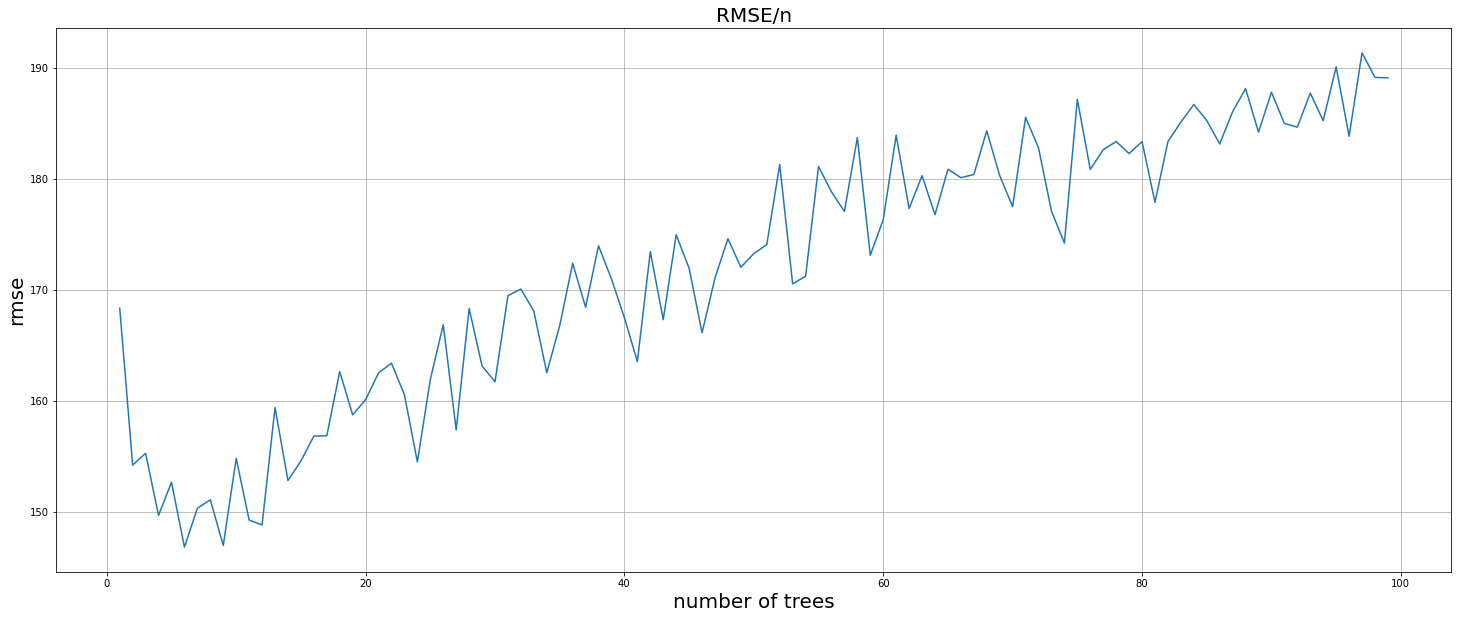

In [3]:
n = np.arange(1, 100)
t = []
rmse = []
for i in n:
    start = time.time()
    rf = RandomForestMSE(n_estimators=i, max_depth=10)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    t.append(time.time() - start)
    rmse.append(math.sqrt(mean_squared_error(pred, y_test)))
fig = plt.figure(figsize=(25, 10))
plt.plot(n, rmse)
plt.title('RMSE/n', fontsize=20)
plt.xlabel('number of trees', fontsize=20)
plt.ylabel('rmse', fontsize=20)
plt.grid()
plt.savefig("rf_rmse_tree.pdf")

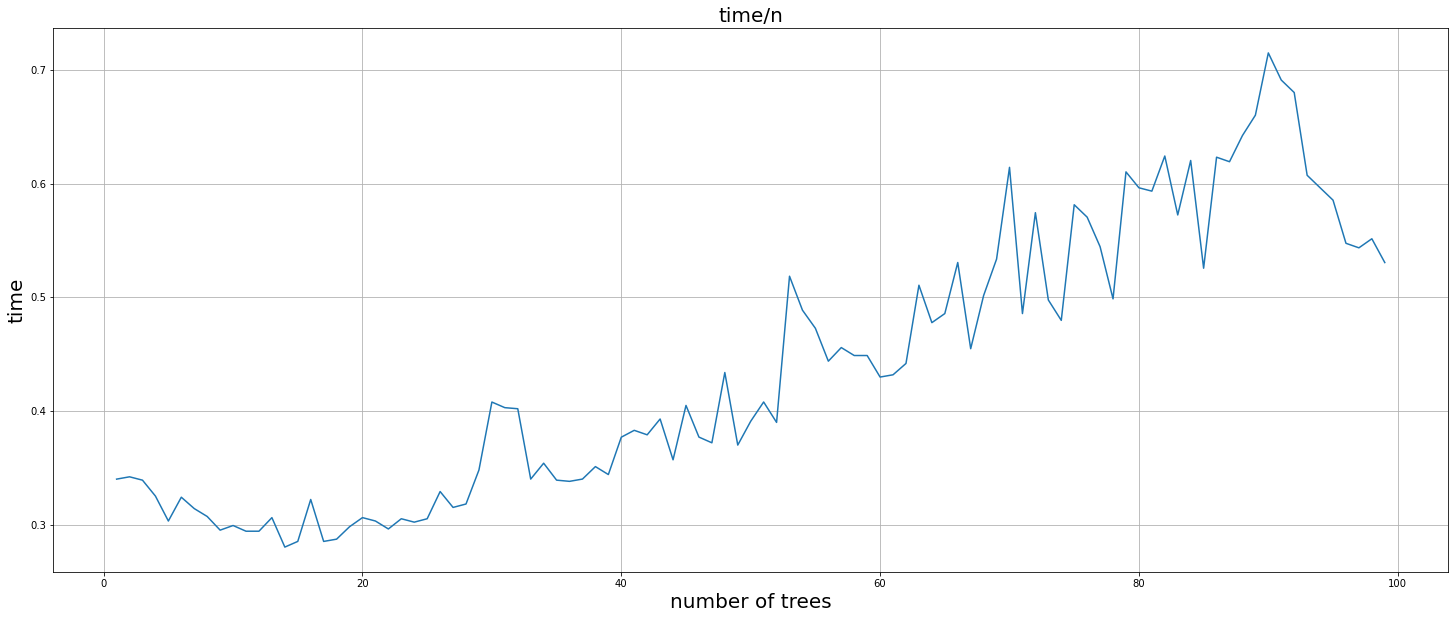

In [4]:
fig = plt.figure(figsize=(25, 10))
plt.plot(n, t)
plt.title('time/n', fontsize=20)
plt.xlabel('number of trees', fontsize=20)
plt.ylabel('time', fontsize=20)
plt.grid()
plt.savefig("rf_rmse_tree_time.pdf")

2. Размерность подвыборки признаков для одного дерева

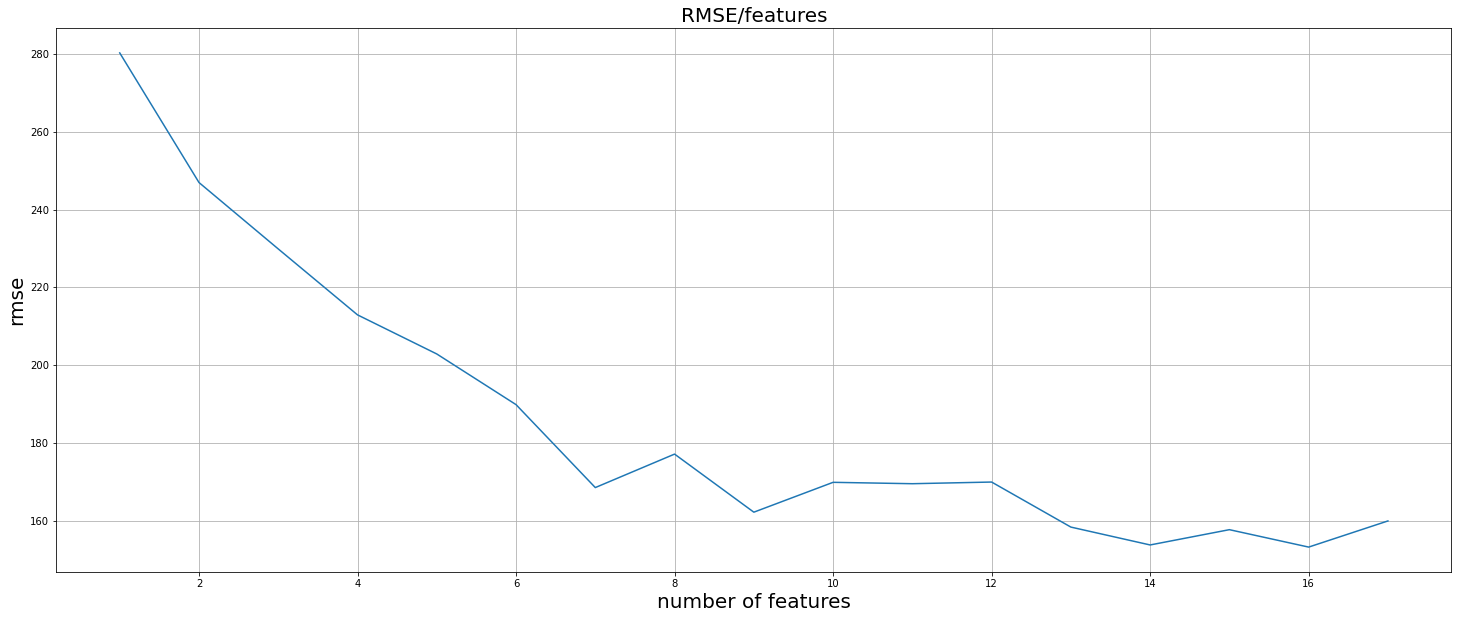

In [5]:
n = np.arange(1, 18)
t = []
rmse = []
for i in n:
    start = time.time()
    rf = RandomForestMSE(n_estimators=10, max_depth=10, feature_subsample_size=i)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    t.append(time.time() - start)
    rmse.append(math.sqrt(mean_squared_error(pred, y_test)))
fig = plt.figure(figsize=(25, 10))
plt.plot(n, rmse)
plt.title('RMSE/features', fontsize=20)
plt.xlabel('number of features', fontsize=20)
plt.ylabel('rmse', fontsize=20)
plt.grid()
plt.savefig("rf_rmse_feat.pdf")

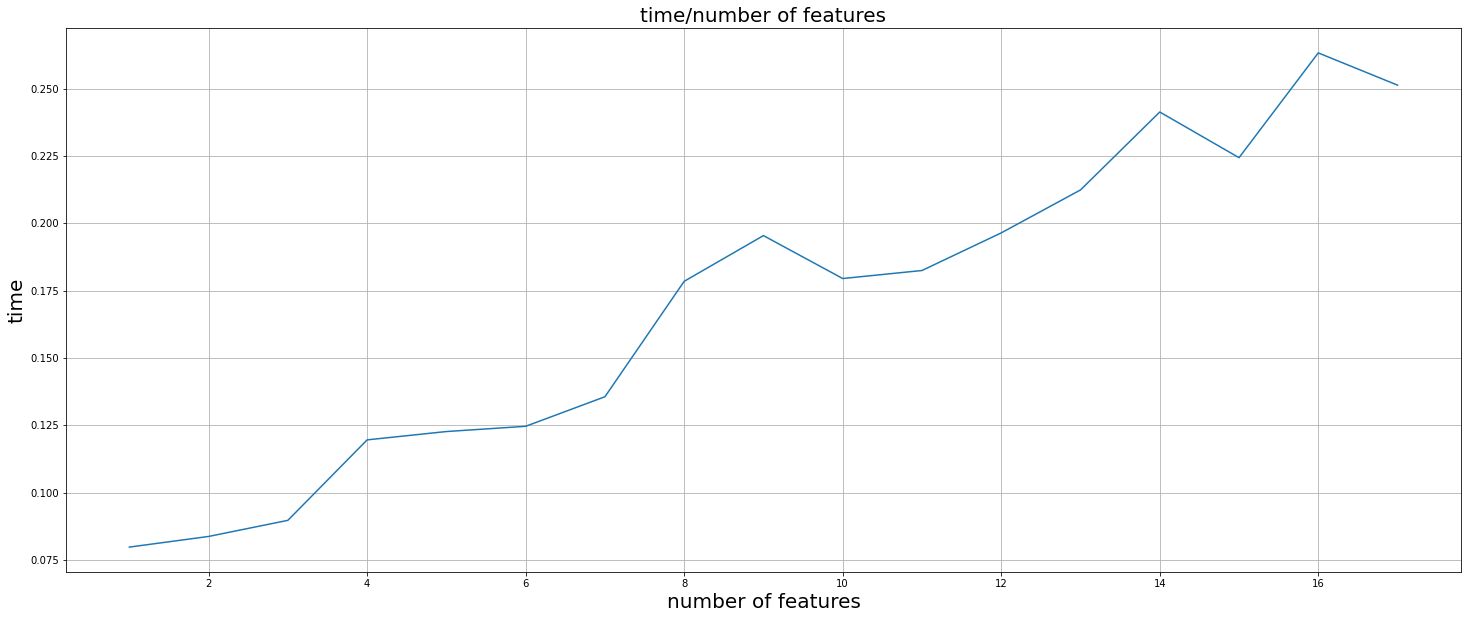

In [6]:
fig = plt.figure(figsize=(25, 10))
plt.plot(n, t)
plt.title('time/number of features', fontsize=20)
plt.xlabel('number of features', fontsize=20)
plt.ylabel('time', fontsize=20)
plt.grid()
plt.savefig("rf_rmse_feat_time.pdf")

3. Максимальная глубина дерева 

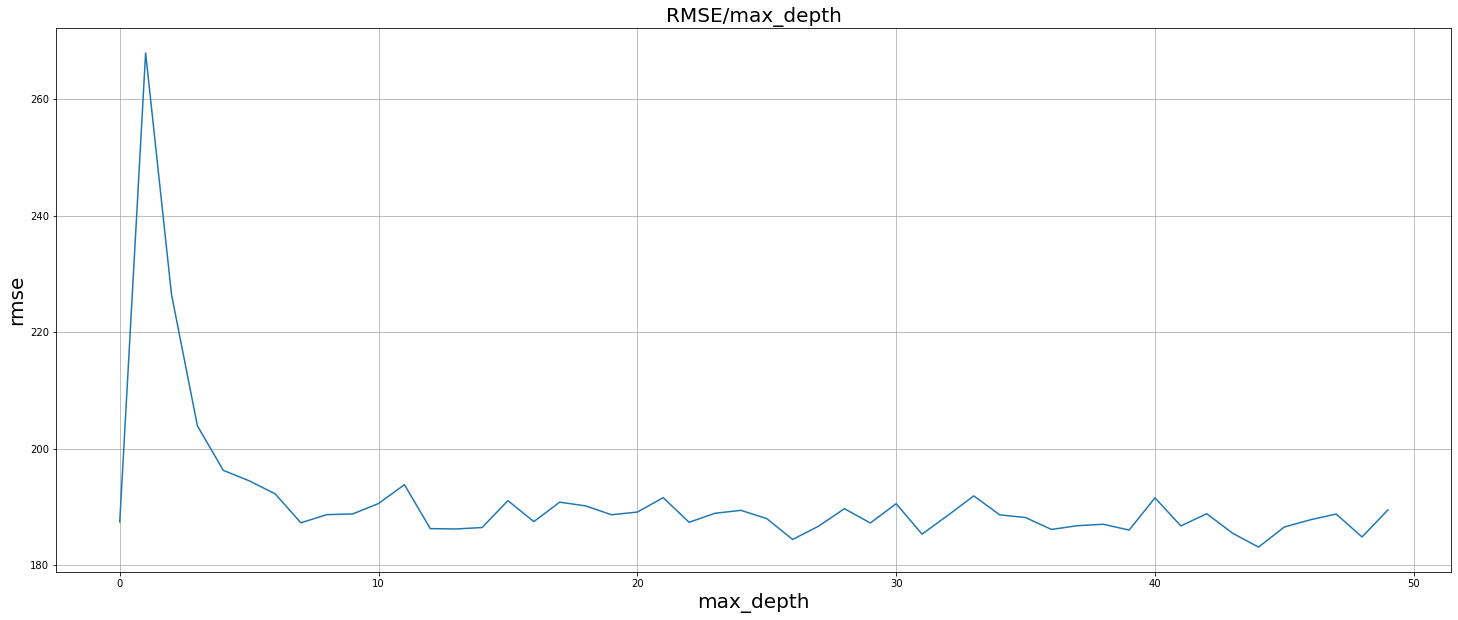

In [7]:
n = np.arange(50)
t = []
rmse = []
for i in n:
    if i == 0:
        i = None
    start = time.time()
    rf = RandomForestMSE(n_estimators=100, max_depth=i)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    t.append(time.time() - start)
    rmse.append(math.sqrt(mean_squared_error(pred, y_test)))
fig = plt.figure(figsize=(25, 10))
plt.plot(n, rmse)
plt.title('RMSE/max_depth', fontsize=20)
plt.xlabel('max_depth', fontsize=20)
plt.ylabel('rmse', fontsize=20)
plt.grid()
plt.savefig("rf_rmse_depth.pdf")

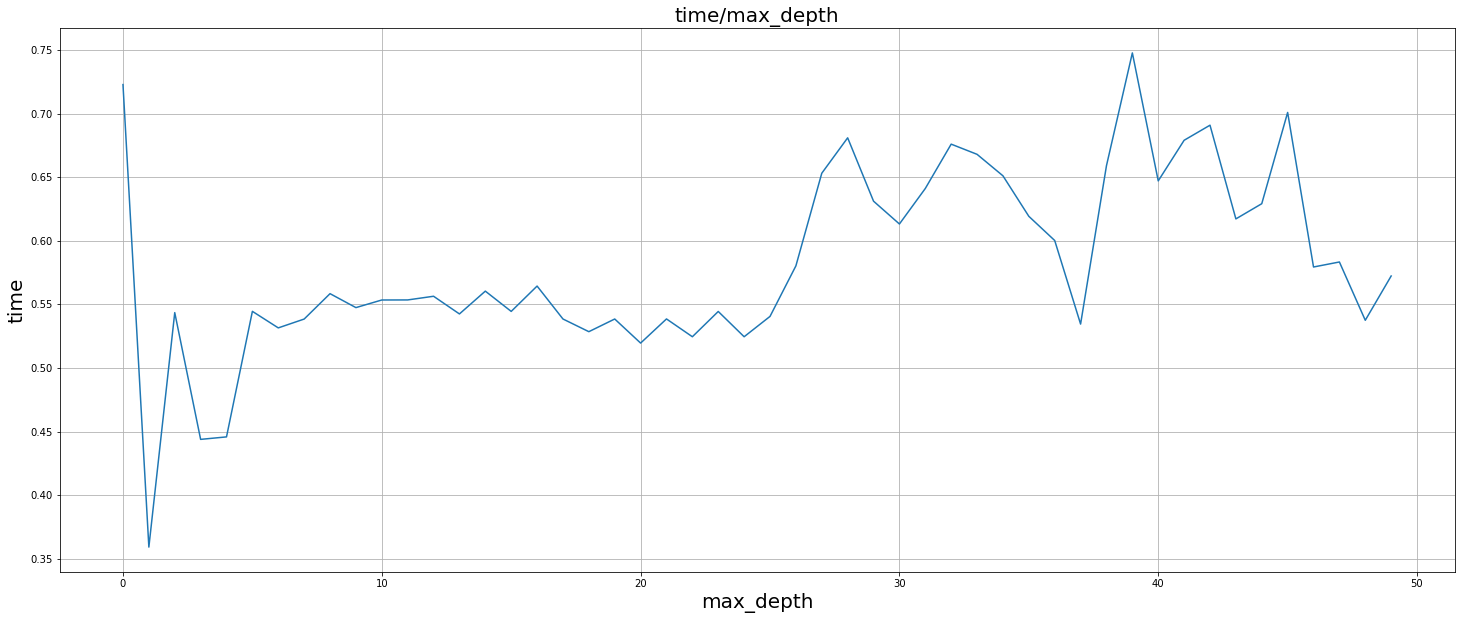

In [8]:
fig = plt.figure(figsize=(25, 10))
plt.plot(n, t)
plt.title('time/max_depth', fontsize=20)
plt.xlabel('max_depth', fontsize=20)
plt.ylabel('time', fontsize=20)
plt.grid()
plt.savefig("rf_rmse_depth_time.pdf")

GradientBoosting

1. Количество деревьев

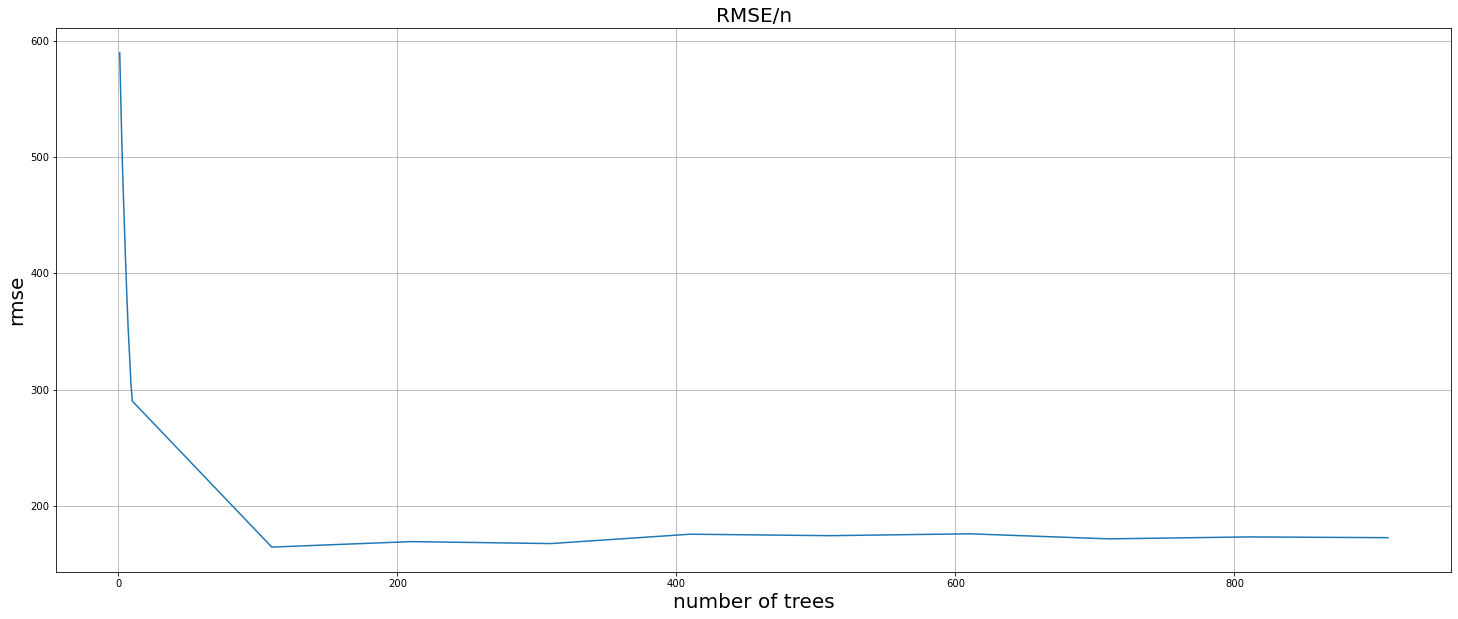

In [9]:
n = np.concatenate((np.arange(1, 10), np.arange(10, 1000, 100)))
t = []
rmse = []
for i in n:
    start = time.time()
    gb = GradientBoostingMSE(n_estimators=i)
    gb.fit(X_train, y_train)
    pred = gb.predict(X_test)
    t.append(time.time() - start)
    rmse.append(math.sqrt(mean_squared_error(pred, y_test)))
fig = plt.figure(figsize=(25, 10))
plt.plot(n, rmse)
plt.title('RMSE/n', fontsize=20)
plt.xlabel('number of trees', fontsize=20)
plt.ylabel('rmse', fontsize=20)
plt.grid()
plt.savefig("gb_rmse_tree.pdf")

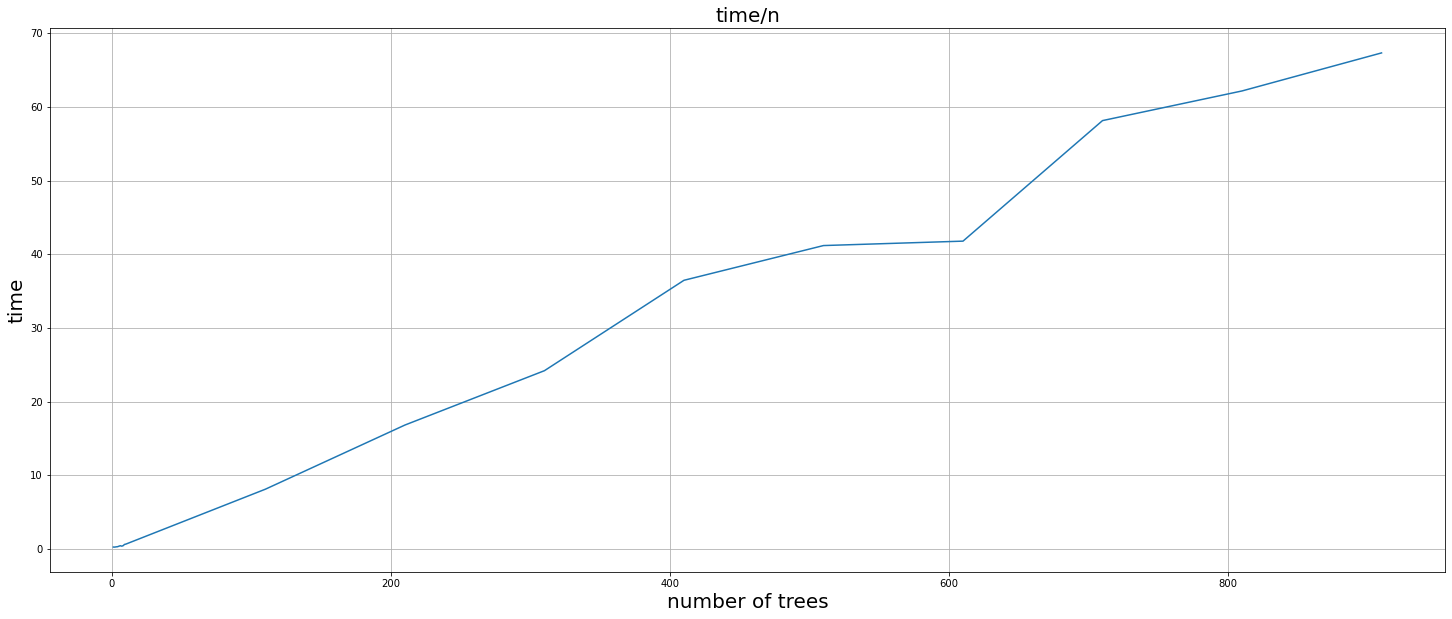

In [10]:
fig = plt.figure(figsize=(25, 10))
plt.plot(n, t)
plt.title('time/n', fontsize=20)
plt.xlabel('number of trees', fontsize=20)
plt.ylabel('time', fontsize=20)
plt.grid()
plt.savefig("gb_rmse_tree_time.pdf")

2. Размерность подвыборки признаков для одного дерева

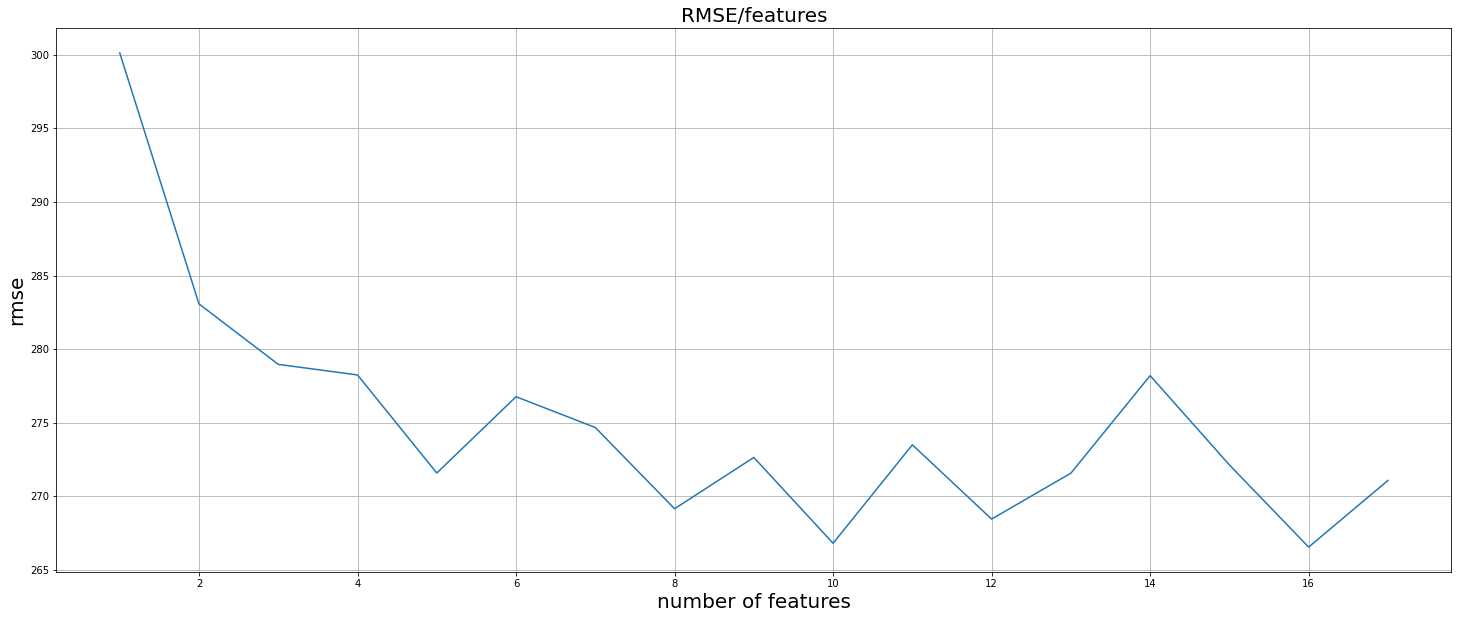

In [10]:
n = np.arange(1, 18)
t = []
rmse = []
for i in n:
    start = time.time()
    gb = GradientBoostingMSE(n_estimators=10, max_depth=10, learning_rate=0.1, feature_subsample_size=i)
    gb.fit(X_train, y_train)
    pred = gb.predict(X_test)
    t.append(time.time() - start)
    rmse.append(math.sqrt(mean_squared_error(pred, y_test)))
fig = plt.figure(figsize=(25, 10))
plt.plot(n, rmse)
plt.title('RMSE/features', fontsize=20)
plt.xlabel('number of features', fontsize=20)
plt.ylabel('rmse', fontsize=20)
plt.grid()
plt.savefig("gb_rmse_feat.pdf")

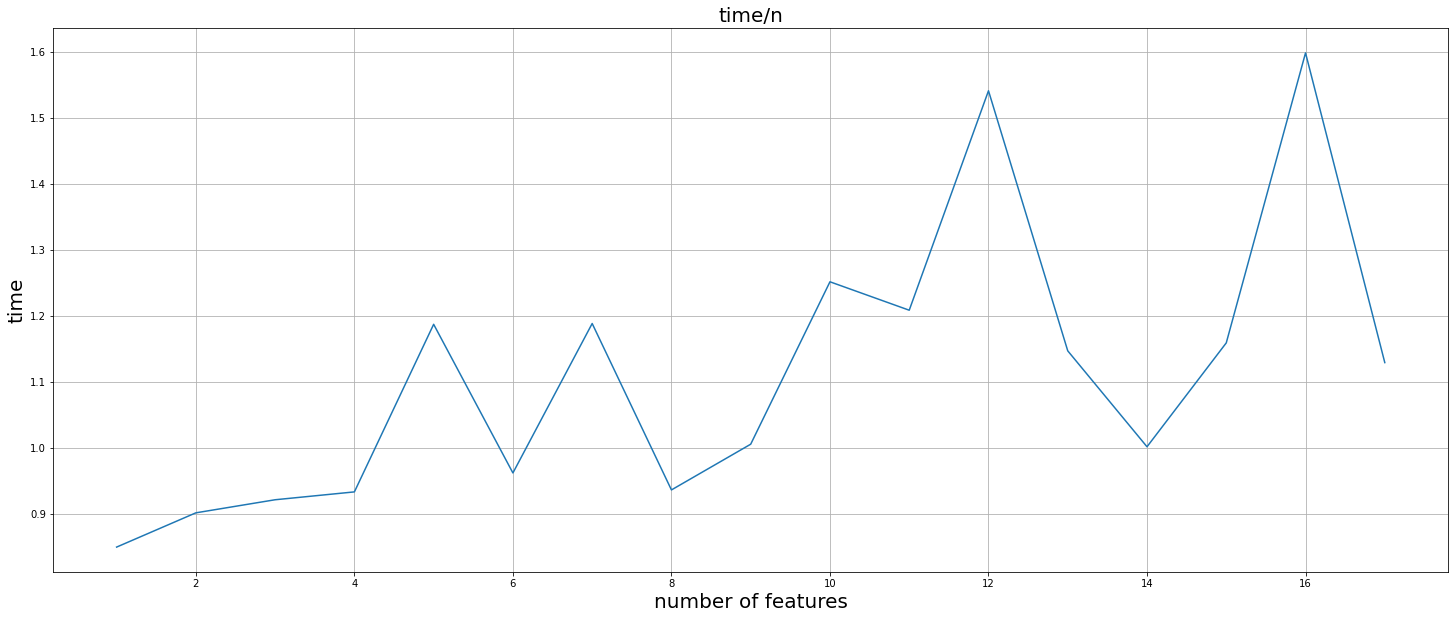

In [11]:
fig = plt.figure(figsize=(25, 10))
plt.plot(n, t)
plt.title('time/n', fontsize=20)
plt.xlabel('number of features', fontsize=20)
plt.ylabel('time', fontsize=20)
plt.grid()
plt.savefig("gb_rmse_feat_time.pdf")

3. Максимальная глубина дерева 

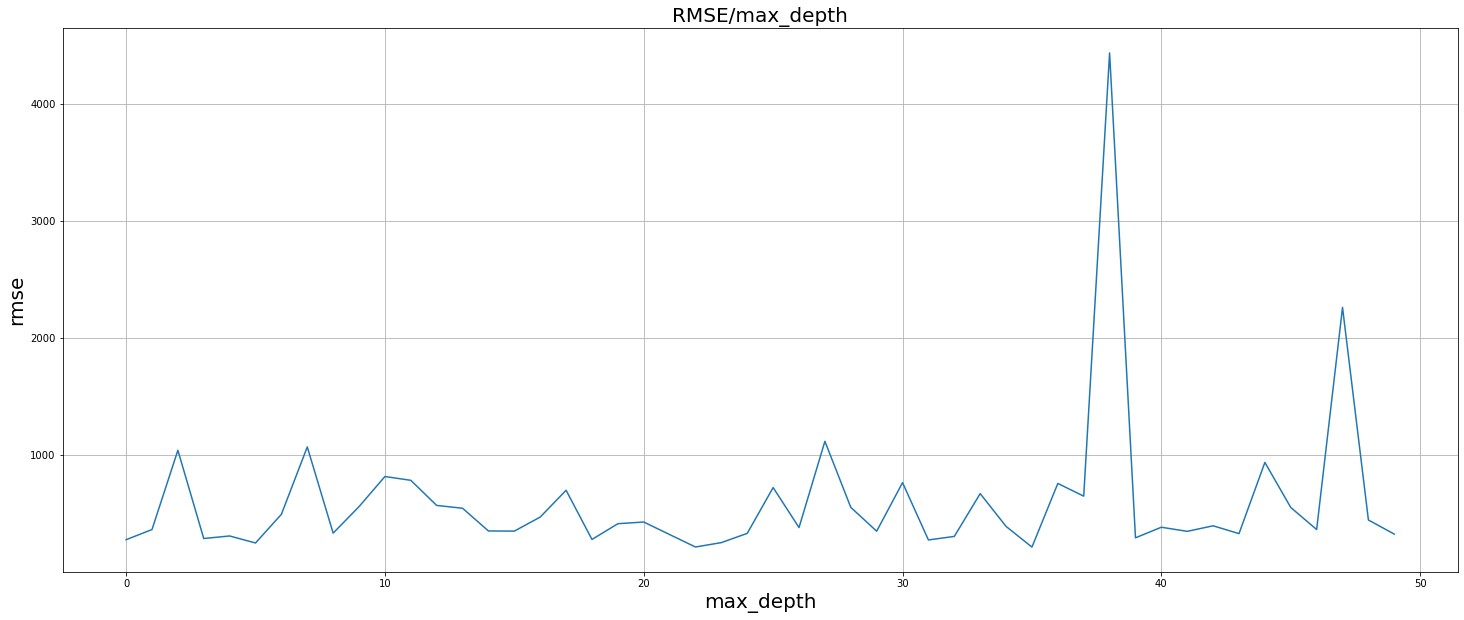

In [11]:
n = np.arange(50)
t = []
rmse = []
for i in n:
    if i == 0:
        i = None
    start = time.time()
    gb = GradientBoostingMSE(n_estimators=100, max_depth=i, learning_rate=0.1, feature_subsample_size=18)
    gb.fit(X_train, y_train)
    pred = gb.predict(X_test)
    t.append(time.time() - start)
    rmse.append(math.sqrt(mean_squared_error(pred, y_test)))
fig = plt.figure(figsize=(25, 10))
plt.plot(n, rmse)
plt.title('RMSE/max_depth', fontsize=20)
plt.xlabel('max_depth', fontsize=20)
plt.ylabel('rmse', fontsize=20)
plt.grid()
plt.savefig("gb_rmse_dept.pdf")

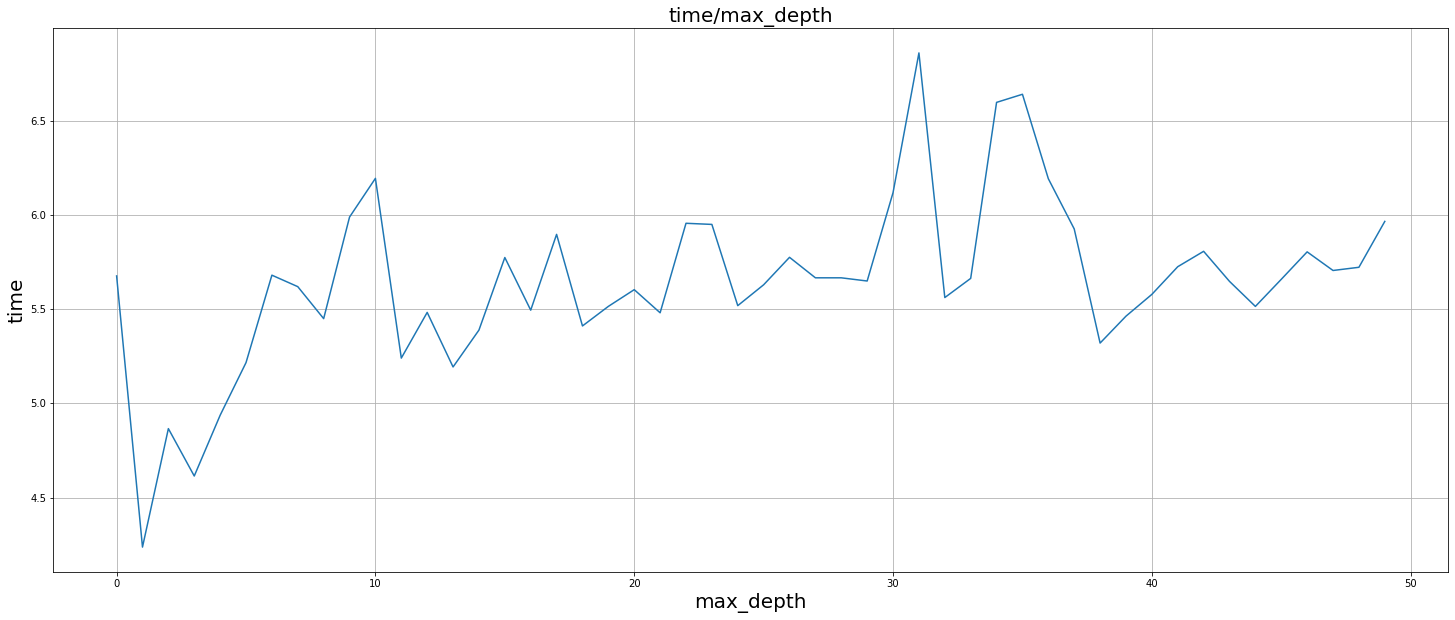

In [12]:
fig = plt.figure(figsize=(25, 10))
plt.plot(n, t)
plt.title('time/max_depth', fontsize=20)
plt.xlabel('max_depth', fontsize=20)
plt.ylabel('time', fontsize=20)
plt.grid()
plt.savefig("gb_rmse_dept_time.pdf")

4. Выбранный learning_rate

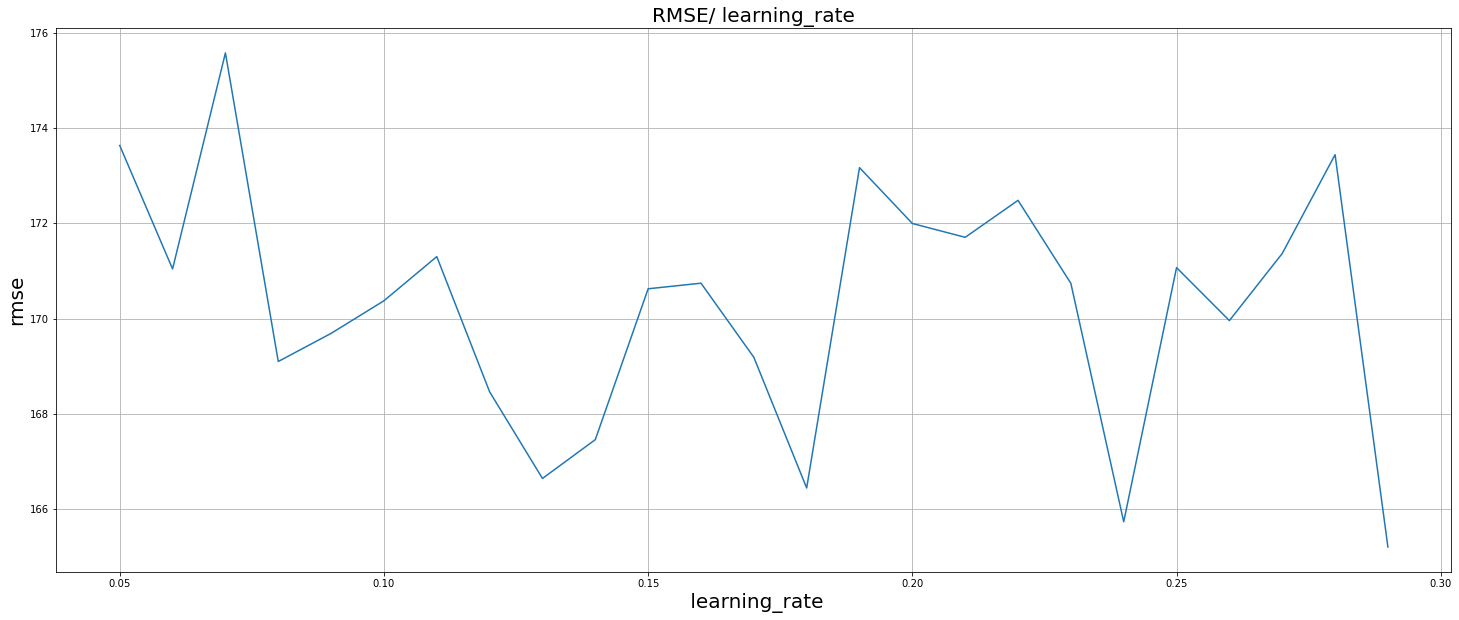

In [13]:
n = np.arange(0.05, 0.3, 0.01)
t = []
rmse = []
for i in n:
    start = time.time()
    gb = GradientBoostingMSE(n_estimators=300, max_depth=5, learning_rate=i)
    gb.fit(X_train, y_train)
    pred = gb.predict(X_test)
    t.append(time.time() - start)
    rmse.append(math.sqrt(mean_squared_error(pred, y_test)))
fig = plt.figure(figsize=(25, 10))
plt.plot(n, rmse)
plt.title('RMSE/ learning_rate', fontsize=20)
plt.xlabel(' learning_rate', fontsize=20)
plt.ylabel('rmse', fontsize=20)
plt.grid()
plt.savefig("gb_rmse_lr.pdf")

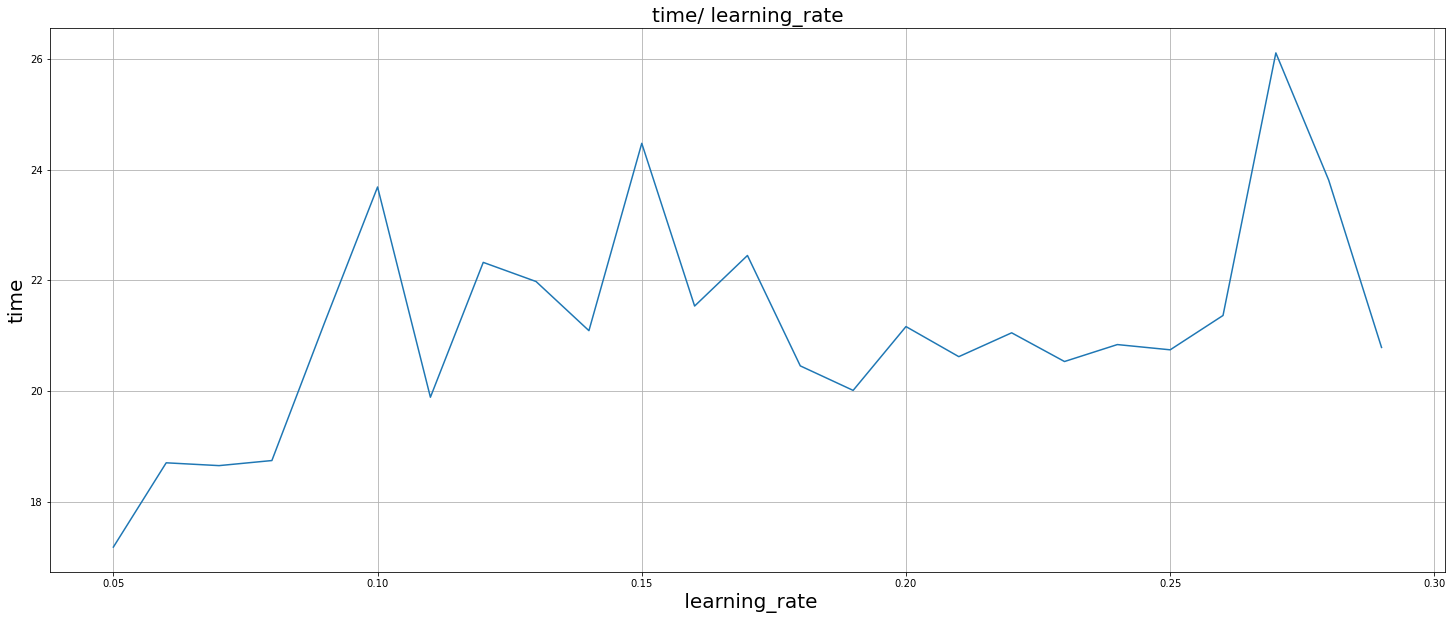

In [14]:
fig = plt.figure(figsize=(25, 10))
plt.plot(n, t)
plt.title('time/ learning_rate', fontsize=20)
plt.xlabel(' learning_rate', fontsize=20)
plt.ylabel('time', fontsize=20)
plt.grid()
plt.savefig("gb_rmse_lr_time.pdf")